In [1]:
# Useful libraries
import numpy as np

# Random data sets
from sklearn.datasets import make_blobs, make_moons, make_circles
from sklearn import datasets

# Plotting
import matplotlib.pyplot as plt

# K - Means Clustering

This notebook implements a DIY k-means class, with the following functions:

* init_centroids: initializes the centroids with k-means++ (doesn't need to be called)
* set_centroids: initialize centroids with some other input
* fit: fits to the best solution using the k-means algorithm
* single_update: does a single iteration of the fit process, useful if you want to plot individual steps
* update_clusters: updates the data to the correct cluster assignment
* update_centroids: recalculates centroids based on average value of cluster members
* plot_all: plots the clusters and centroids, using the first two data dimensions 
* predict: predicts which cluster new data should belong to

In [2]:
class KMeans:
    
    def __init__(self,x,n_clusters = 2, max_iter = 300):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.x = x
        self.labels_ = np.zeros((self.x.shape[0],1))
        self.r = np.zeros((self.x.shape[0],n_clusters))
        self.centroids = self.init_centroids()
        self.update_clusters()
    
    # Use k-means++ to initalize
    def init_centroids(self):
        # Start with just one centroid
        centroids = np.random.permutation(self.x)[0].reshape(1,-1)
        
        for ii in range(1,self.n_clusters):
            # Find distance (squared) between current centroids and all x
            x2 = np.sum(self.x*self.x,1,keepdims=True)
            mu2 = np.sum(centroids*centroids,1,keepdims=True)
            xmu = self.x@centroids.T
            diff = x2 + mu2.T - 2*xmu
            
            # Choose closest centroids distance (squared)
            min_val = np.min(abs(diff),axis=1)
            
            # assign to each x a probability, with larger probs for larger distances
            probs = min_val/np.sum(min_val)
            new_centroid = np.random.choice(np.arange(self.x.shape[0]),p=probs)
            centroids = np.vstack([centroids, x[new_centroid]])
            
        return centroids
    
    # set centroids by hand
    def set_centroids(self,centroids):
        self.centroids = centroids
        self.update_clusters()
    
    # Fit, doing max iterations, stopping early if need be
    def fit(self):
        test_change = True
        count = 0
        while count<self.max_iter and test_change:
            old_centroids = self.centroids
            self.update_centroids()
            self.update_clusters()
            if (old_centroids==self.centroids).all():
                test_change = False
                
    # Do a single update, useful for plotting changes as you go
    def single_update(self):
        self.update_centroids()
        self.update_clusters()
                
    # Update indicator matrix, assign each x to a cluster
    def update_clusters(self):
        self.r,self.labels_ = self.predict(self.x)
    
    # Update centroids to move according to new members
    def update_centroids(self):
        # Update centroids with new averages
        norm = np.sum(self.r,axis=0,keepdims=True).T
        empty_classes = np.where(norm==0)
        mu_new = self.r.T@self.x
        # if a class has nobody in it, don't update it
        if empty_classes[0].shape[0]>0:
            norm[empty_classes]=1
            mu_new[empty_classes[0],:] = self.centroids[empty_classes[0],:]
            
        self.centroids = mu_new/norm
        
    # Predict which cluster new data would belong to
    def predict(self,x):
        # Euclidean distance between each element of x and each centroid
        x2 = np.sum(x*x,1,keepdims=True)
        mu2 = np.sum(self.centroids*self.centroids,1,keepdims=True)
        xmu = x@self.centroids.T
        diff = x2 + mu2.T - 2*xmu
        
        # Find the closest centroid, assign appropriate indicator variables
        min_val = np.min(diff,axis=1,keepdims=True)
        r_nk = (diff==min_val).astype(float)
        
        # If the distance to 2 classes are the same, pick one at random 
        check_sum, = np.where(np.sum(r_nk,1)>1)
        for idx in check_sum:
            possible_class, = np.where(r_nk[idx]==1)
            random_class = np.random.permutation(possible_class)[1:]
            r_nk[idx,random_class] = 0
        
        r = r_nk
        labels = np.where(r_nk)[1].reshape(-1)
        return r,labels 
    
    # Plotting function
    def plot_all(self,**kwargs):
        try:
            x = kwargs['x']
        except:
            x = self.x
        r,labels = self.predict(x)
        try:
            title = kwargs['title']
        except:
            title = 'Current Clusters and Centroids'
        plt.scatter(x[:,0],x[:,1],c=labels,cmap=plt.cm.Set3)
        plt.scatter(self.centroids[:,0],self.centroids[:,1],marker = 'x',s=200,c='k')
        plt.title(title)

Now let's test this class on a few different test datasets:

* blobs: should do reasonably well on this, as it is convex
* moons: shouldn't fit this at all, as it's non-convex
* circles: shouldn't fit this at all, as it's non-convex
* iris: standard iris dataset

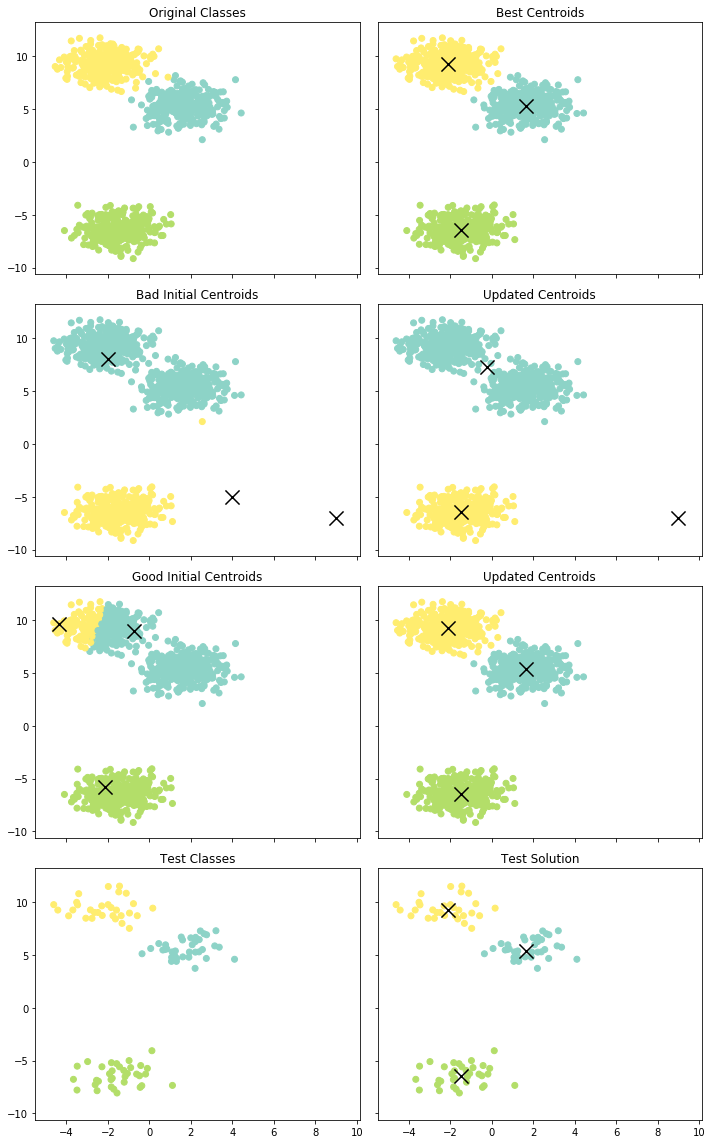

In [3]:
n_centers = 3
n_clusters = 3
n_data = 1000
n_train = 900

centroids_bad = np.array([[-2,8],[4,-5],[9,-7],[1,5],[-7,8],[-6,-5],[7,6],[5,-1],[-10,0],[0,0]])
x,y = make_blobs(n_data, centers = n_centers)

fig1,ax1 = plt.subplots(4,2,figsize=(10, 16),sharey=True,sharex=True)
plt.sca(ax1[0,0])
plt.scatter(x[np.arange(n_train),0],x[np.arange(n_train),1],c=y[np.arange(n_train)],cmap=plt.cm.Set3)
plt.title('Original Classes')


plt.sca(ax1[1,0])
km = KMeans(x,n_clusters)
centroids_bad = centroids_bad[0:n_clusters]
km.set_centroids(centroids_bad)
km.plot_all(title = 'Bad Initial Centroids')

plt.sca(ax1[1,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()

plt.sca(ax1[2,0])
km = KMeans(x,n_clusters)
km.plot_all(title = 'Good Initial Centroids')

plt.sca(ax1[2,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()

plt.sca(ax1[0,1])
km.fit()
km.plot_all(title = 'Best Centroids')
plt.tight_layout()

plt.sca(ax1[3,0])
plt.scatter(x[np.arange(n_train,n_data),0],x[np.arange(n_train,n_data),1],c=y[np.arange(n_train,n_data)],cmap=plt.cm.Set3)
plt.title('Test Classes')

plt.sca(ax1[3,1])
km.plot_all(x=x[np.arange(n_train,n_data)],title = 'Test Solution')

plt.show()

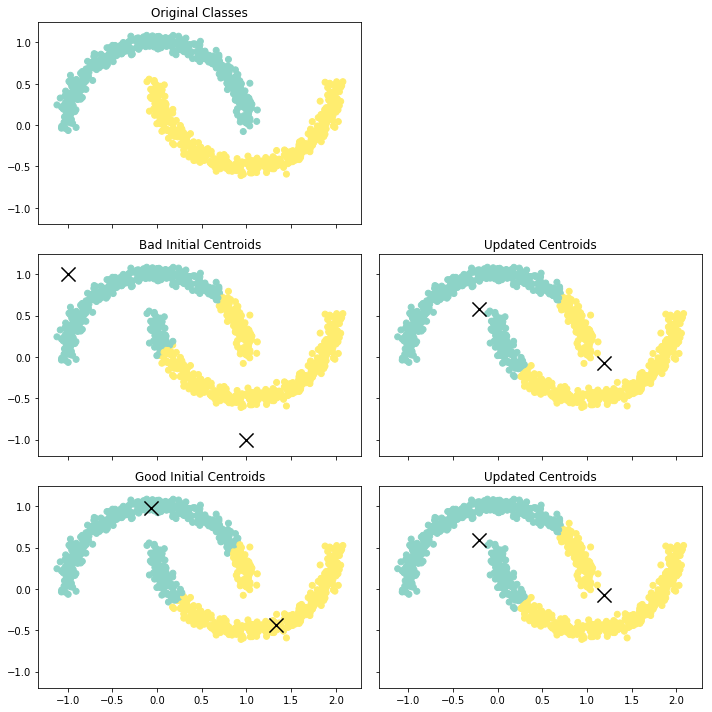

In [4]:
n_clusters = 2
n_data = 1000
centroids_bad = np.array([[-1,1],[1,-1],[0,0],[1,5],[-7,8],[-6,-5],[7,6],[5,-1],[-10,0],[0,0]])
x,y = make_moons(n_data, noise=.05)

fig1,ax1 = plt.subplots(3,2,figsize=(10, 10),sharey=True,sharex=True)
plt.sca(ax1[0,0])
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.Set3)
plt.title('Original Classes')

ax1[0,1].set_axis_off()


plt.sca(ax1[1,0])
km = KMeans(x,n_clusters)
centroids_bad = centroids_bad[0:n_clusters]
km.set_centroids(centroids_bad)
km.plot_all(title = 'Bad Initial Centroids')

plt.sca(ax1[1,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()

plt.sca(ax1[2,0])
km = KMeans(x,n_clusters)
km.plot_all(title = 'Good Initial Centroids')

plt.sca(ax1[2,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()
plt.show()

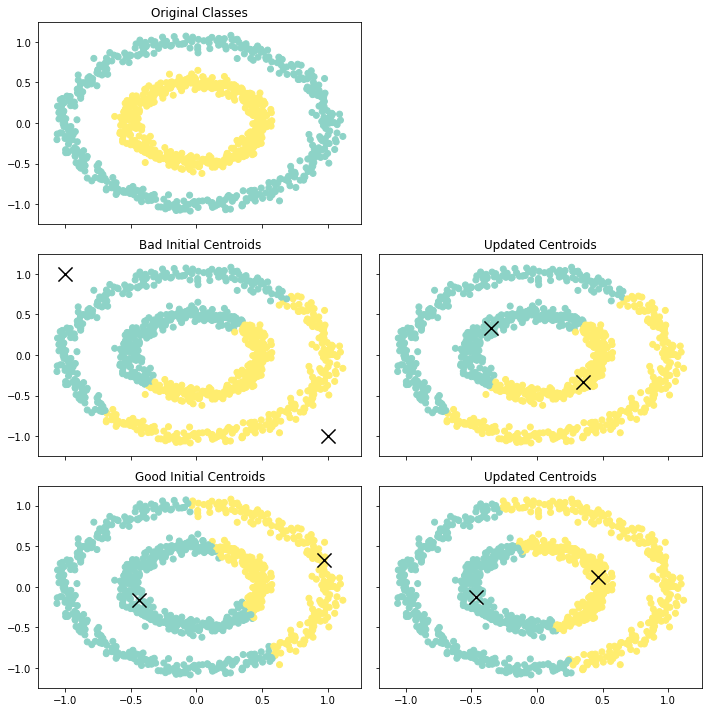

In [5]:
n_clusters = 2
n_data = 1000
centroids_bad = np.array([[-1,1],[1,-1],[0,0],[1,5],[-7,8],[-6,-5],[7,6],[5,-1],[-10,0],[0,0]])
x,y = make_circles(n_data, noise=.05, factor=.5)

fig1,ax1 = plt.subplots(3,2,figsize=(10, 10),sharey=True,sharex=True)
plt.sca(ax1[0,0])
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.Set3)
plt.title('Original Classes')

ax1[0,1].set_axis_off()


plt.sca(ax1[1,0])
km = KMeans(x,n_clusters)
centroids_bad = centroids_bad[0:n_clusters]
km.set_centroids(centroids_bad)
km.plot_all(title = 'Bad Initial Centroids')

plt.sca(ax1[1,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()

plt.sca(ax1[2,0])
km = KMeans(x,n_clusters)
km.plot_all(title = 'Good Initial Centroids')

plt.sca(ax1[2,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()
plt.show()

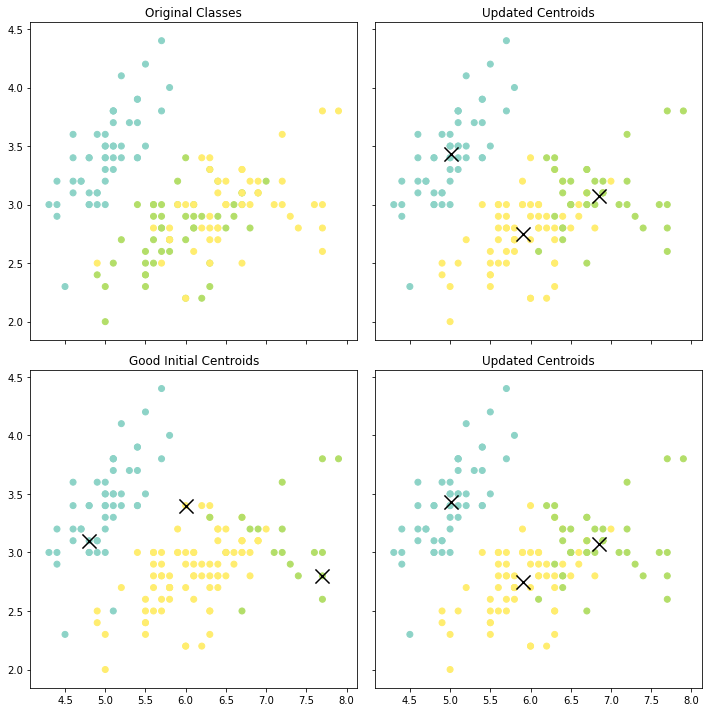

In [10]:
iris = datasets.load_iris()
x = iris.data
y = iris.target

n_clusters = 3

fig1,ax1 = plt.subplots(2,2,figsize=(10, 10),sharey=True,sharex=True)
plt.sca(ax1[0,0])
plt.scatter(x[:,0],x[:,1],c=y,cmap=plt.cm.Set3)
plt.title('Original Classes')

plt.sca(ax1[1,0])
km = KMeans(x,n_clusters)
km.plot_all(title = 'Good Initial Centroids')

plt.sca(ax1[1,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()

plt.sca(ax1[0,1])
km.fit()
km.plot_all(title = 'Updated Centroids')
plt.tight_layout()
plt.show()